In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory
rm: cannot remove 'results_fwd': No such file or directory
rm: cannot remove 'results_fwd_norefl': No such file or directory


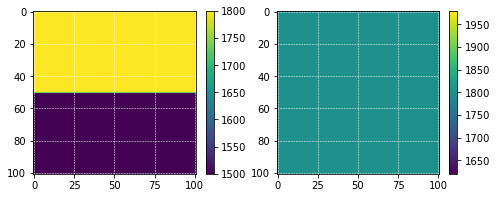

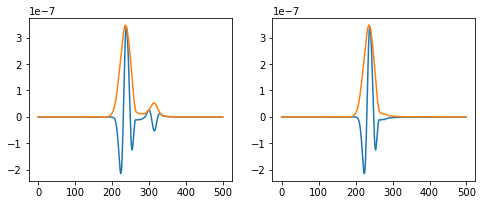

In [2]:
## with reflections
!makevel nz=51 nx=$nx v000=1800 > vp1
!makevel nz=50 nx=$nx v000=1500 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup.in > out_fwd

!rm -r results_fwd; mv results  results_fwd
!(cd results_fwd; suenv < dsyn_Shot0001.su > denv_Shot0001.su)

## w/o reflections
!makevel nz=$nz nx=$nx v000=1800 > model

!../../exe/FWD setup.in > out_fwd_norefl

!rm -r results_fwd_norefl; mv results  results_fwd_norefl
!(cd results_fwd_norefl; suenv < dsyn_Shot0001.su > denv_Shot0001.su)

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd/denv_Shot0001.su'))

plt.subplot(1,2,2)
plt.plot(read_su('results_fwd_norefl/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/denv_Shot0001.su'))

## PFEI estimate wavelet for envelope modeling

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


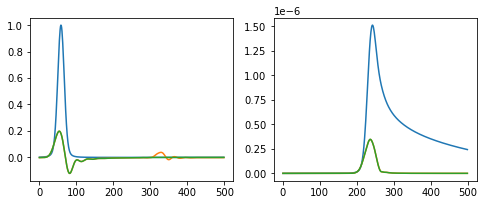

In [24]:
## w/o reflections
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup.in setup_wl.in
!echo "WAVELET_TYPE   'ricker envelope'" >> setup_wl.in
!echo "FILE_DATA_PREFIX    'results_fwd_norefl/denv_Shot'" >> setup_wl.in
!echo "JOB    'estimate wavelet'" >> setup_wl.in

!../../exe/PFEI setup_wl.in > out_wl
!rm -r results_wl; mv results results_wl
!(cd results_wl; sumute < updated_wavelet.su key=tracl xmute=1   ntaper=50 mode=1  tmute=1.8 > muted_updated_wavelet.su)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_wl/wavelet.su'))
plt.plot(read_su('results_wl/updated_wavelet.su'))
plt.plot(read_su('results_wl/muted_updated_wavelet.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_wl/RE0_Shot0001.su'))
plt.plot(read_su('results_wl/updated_RE0_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/denv_Shot0001.su'))

## PFEI gradient for tilD

In [41]:
# # with reflections
# !makevel nz=51 nx=$nx v000=1800 > vp1
# !makevel nz=50 nx=$nx v000=1500 > vp2
# !cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
# !rm vp1 vp2 rho1 rho2 tmp*

# w/o reflections
!makevel nz=$nz nx=$nx v000=1800 > model

!makevel nz=1 nx=$nx v000=100 > topo
#makevel nz=1 nx=$nx v000=400 > topo

!cp setup.in setup_grad.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_grad.in

!../../exe/PFEI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


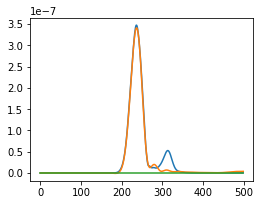

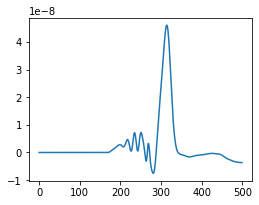

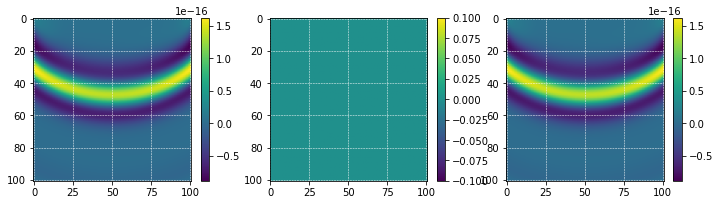

In [42]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read('results_grad/gtilD_dt2'); imshow(tmp1)
plt.subplot(1,3,2);tmp2=1800**2*read('results_grad/gtilD_nab2'); imshow(tmp2)
plt.subplot(1,3,3);imshow(tmp1-tmp2)

# plt.figure(figsize=(12,3))
# plt.subplot(1,3,1);imshow(signal.medfilt2d(tmp1))
# plt.subplot(1,3,2);imshow(signal.medfilt2d(tmp2))
# plt.subplot(1,3,3);imshow(signal.medfilt2d(tmp1)-signal.medfilt2d(tmp2))

## GradientTest

In [43]:
!make

!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
!echo "ALPHAS '-1e-2 -1e-3 -1e-4 1e-4 1e-3 1e-2' " >> setup_test.in
#!echo "ARTIFICIAL_SCALER_ON_dE     1e-3" >> setup_test.in
artifical=1

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

In [67]:
!make

!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
# !echo "DESCENT_DIR   'stack'" >> setup_test.in
!echo "PRECO   'none'" >> setup_test.in
!echo "ALPHAS '-1e-2 -0.5e-3 -1e-3 -0.5e-4 -1e-4' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

In [69]:
!make

!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
# !echo "DESCENT_DIR   'stack'" >> setup_test.in
!echo "PRECO   'none'" >> setup_test.in
!echo "ALPHAS '1e-2 0.5e-3 1e-3 0.5e-4 1e-4' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

In [70]:
!make

!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
# !echo "DESCENT_DIR   'stack'" >> setup_test.in
!echo "PRECO   'none'" >> setup_test.in
!echo "ALPHAS '0.5e-5 1e-5 0.5e-6 1e-6' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

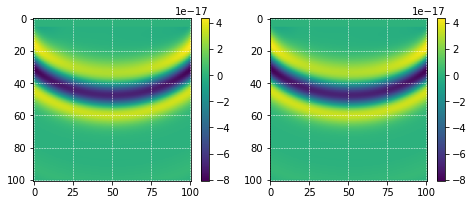

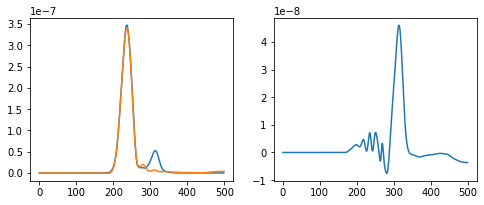

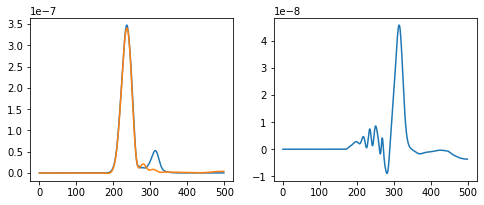

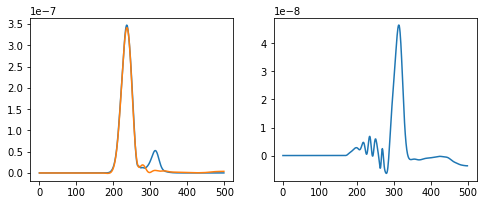

In [68]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imshow(read('results/qp0%g'))
plt.subplot(1,3,2)
imshow(read('results/qp0%pg'))
# plt.subplot(1,3,3)
# imshow(read('results/curr%d'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/denv_Shot0001.su')-read_su('results_grad/RE0_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results/dadj_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/denv_Shot0001.su')-(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su')))


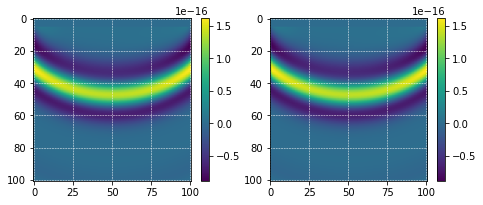

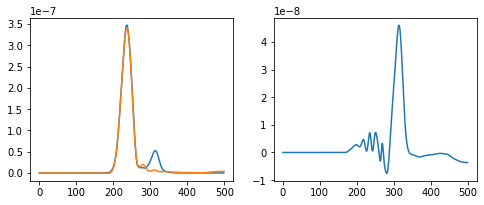

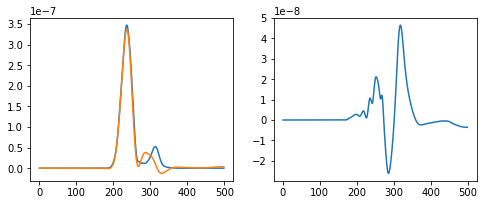

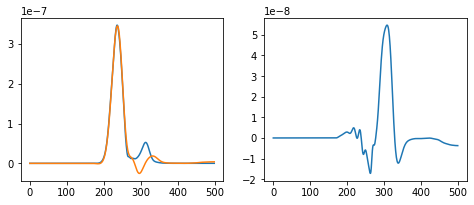

In [47]:
#old
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imshow(read('results/qp0%g'))
plt.subplot(1,3,2)
imshow(read('results/qp0%pg'))
# plt.subplot(1,3,3)
# imshow(read('results/curr%d'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/denv_Shot0001.su')-read_su('results_grad/RE0_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results/dadj_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/denv_Shot0001.su')-(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su')))


## PFEI gradient for vp2

In [ ]:
# plt.plot(read_su('results_wl/wavelet.su'))
# plt.plot(read_su('results_wl/updated_wavelet.su'))
# plt.plot(read_su('results_wl/muted_updated_wavelet.su'))
# suximage < results_grad/RE0_Shot0001.su clip=1e-5 &
# suximage < results_grad/RdE_Shot0001.su clip=1e-5 &
# susum  results_grad/RE0_Shot0001.su  results_grad/RdE_Shot0001.su | suximage clip=1e-5 &
#
# ximage < results_grad/gvp2_F1_star_E0 title=gvp2_F1_star_E0 n1=101 clip=1e-19 &
# ximage < results_grad/gvp2_F2_star_dE title=gvp2_F2_star_dE n1=101 clip=1e-19 &
# ximage < results_grad/gvp2_F2_star_E0 title=gvp2_F2_star_E0 n1=101 clip=1e-19 &